In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#model = tf.keras.models.load_model('../ML/data/training.h5')#, custom_objects=None, compile=False)

#model._make_predict_function()
#graph = tf.get_default_graph()

#def run_model(inputs):
#    global graph
#    with graph.as_default():
#        outputs = model.predict(inputs)
#    return outputs

os.environ['KERAS_BACKEND'] = 'theano'
from keras.models import load_model

#model = load_model('../ML/data/training.h5')

Using Theano backend.


In [3]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [4]:
#Let's define our processor first. 

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
    
        #Great, now let's define some bins for our histograms.
        
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        #pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 15, 0, 300)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)
        phi_axis             = hist.Bin("phi", r"$\Delta \phi$", 80, 0, 8)
        mass_axis            = hist.Bin("mass", r"mass (GeV)", 500, 0, 2000)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        score_axis           = hist.Bin("score", r"NN Score", 10, 0, 1)


        self._accumulator = processor.dict_accumulator({
           "met":                               hist.Hist("Counts", dataset_axis, pt_axis)
        })

    
    @property
    
    def accumulator(self):
        return self._accumulator

    def process(self, df):
     
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        #cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Muons
        muon = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            miniPFRelIso_all=df['Muon_miniPFRelIso_all'].content,
            looseId =df['Muon_looseId'].content
            )
        muon = muon[(muon.pt > 10) & (abs(muon.eta) < 2.4) & (muon.looseId) & (muon.miniPFRelIso_all < 0.2)]
        #muon = Collections(df, "Muon", "tightTTH").get() # this needs a fix for DASK
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        ## Electrons
        electron = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt = df['Electron_pt'].content,
            eta = df['Electron_eta'].content,
            phi = df['Electron_phi'].content,
            mass = df['Electron_mass'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            cutBased=df['Electron_cutBased'].content
            )
        electron = electron[(electron.pt>10) & (abs(electron.eta) < 2.4) & (electron.miniPFRelIso_all < 0.1) &  (electron.cutBased >= 1)]
        #electron = Collections(df, "Electron", "tightTTH").get() # this needs a fix for DASK
        
        tau = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        tau = tau[(tau.pt > 20) & (abs(tau.eta) < 2.4) & (tau.decaymode) & (tau.newid >= 8)]
        
        isotrack = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        isotrack = isotrack[(isotrack.pt > 10) & (abs(isotrack.eta) < 2.4) & ((isotrack.rel_iso < 0.1) | ((isotrack.rel_iso*isotrack.pt) < 6))]
        
        ## FatJets
        fatjet = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt = df['FatJet_pt'].content,
            eta = df['FatJet_eta'].content,
            phi = df['FatJet_phi'].content,
            mass = df['FatJet_mass'].content,
            msoftdrop = df["FatJet_msoftdrop"].content,  
            deepTagMD_HbbvsQCD = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            deepTagMD_WvsQCD = df['FatJet_deepTagMD_WvsQCD'].content, 
            deepTag_WvsQCD = df['FatJet_deepTag_WvsQCD'].content
            
        )
       
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            #puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
            #deepJet = df['Jet_'].content # not there yet?
        )
        
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        

        #Now it's time to make some selections.


        bjet0_ps = (btag.counts==0)
     
    
        e_sel = (electron.counts == 0)
        m_sel = (muon.counts == 0)
        it_sel = (isotrack.counts == 0)
        t_sel = (tau.counts == 0)
        #l_sel = e_sel & m_sel & it_sel & t_sel
        l_sel = ((electron.counts + muon.counts) == 1)
        l_veto = (e_sel & m_sel & t_sel & it_sel)
        

        inclCR = (l_sel & bjet0_ps) if dataset=='WJets_old' else (l_sel & bjet0_ps & (df['stitch']==1) )

        #Let's make sure we weight our events properly.
        #wght = df['weight'][sel] * 137
        weight = df['weight']
        lumi = 60

        wghtCR = weight[inclCR] * lumi
 
        
        #Let's fill some histograms. 
       
        output['met'].fill(dataset=dataset, pt=met_pt[inclCR].flatten(), weight=wghtCR)
    
        return output

    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
fileset_W_2018 = {'WJets_old':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W1JetsToLNu_Tune*RunIIAutumn18*/*.root')
             + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W2JetsToLNu_Tune*RunIIAutumn18*/*.root')
             + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W4JetsToLNu_Tune*RunIIAutumn18*/*.root'),
            'WJets_new': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p31/W1JetsToLNu_*RunIIAutumn18*/*.root')
            +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p31/W2JetsToLNu_*RunIIAutumn18*/*.root')
            +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p31/W4JetsToLNu_*RunIIAutumn18*/*.root')}

output_2018 = processor.run_uproot_job(fileset_W_2018,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 12, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )

HBox(children=(HTML(value='Preprocessing'), FloatProgress(value=0.0, max=142.0), HTML(value='')))

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=163.0), HTML(value='')))

In [14]:
# fileset_W_2017 = {'WJets_old':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W*JetsToLNu_Tune*RunIIFall17*/*.root'),
#             'WJets_new': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p31/W*JetsToLNu_*RunIIFall17*/*.root')}

# output_2017 = processor.run_uproot_job(fileset_W_2017,
#                                     treename='Events',
#                                     processor_instance=WHhadProcessor(),
#                                     executor=processor.futures_executor,
#                                     executor_args={'workers': 12, 'function_args': {'flatten': False}},
#                                     chunksize=500000,
#                                  )

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=126.0), HTML(value='')))

In [6]:
wjets_err_opts_rat = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color':'#8AC926',
    'elinewidth': 1}

lineOverlayOpts = {
    'color': [('#1982C4'),('#F76F8E')]
}

outdir = "/home/users/mbryson/public_html/dump/WH/kaitlin/"

In [7]:
def saveoverlayshape(hists, outdir, name):
    import re
    wjets_old = hists['WJets_old']
    wjets_new = hists['WJets_new']
    
    plt.rcParams.update({'font.size': 14,'axes.titlesize': 18,'axes.labelsize': 18,
                         'xtick.labelsize': 12,'ytick.labelsize': 12})
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)
    hist.plot1d(hists, overlay="dataset",  ax=ax, clear=False, density = True, stack=False,
                line_opts = lineOverlayOpts, overflow = 'over')
    ax.set_yscale('log')
    ax.set_ylim(0, 1)
    ax.set_xlabel(None)
    leg = ax.legend()
    hist.plotratio(num=wjets_old.sum('dataset'), denom=wjets_new.sum('dataset'), ax=rax, clear = False,
                   error_opts = wjets_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
                   unc='num', overflow = 'over')
    rax.set_ylim(0,2)
    rax.set_ylabel('Ratio')
    fig.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    fig.savefig(os.path.join(outdir, "{}_log.pdf".format(name)))
    fig.clear()

In [8]:
hists_2018 = output_2018["met"]
saveoverlayshape(hists_2018,outdir,"MET_WJets_2018_norebin")
new_pt18_bins1 = hist.Bin('pt',r'MET',40,200,1000)
hists_2018 = hists_2018.rebin('pt',new_pt18_bins1)
saveoverlayshape(hists_2018,outdir,"MET_WJets_2018_40bin")
new_pt18_bins = hist.Bin('pt',r'MET',20,200,1000)
hists_2018 = hists_2018.rebin('pt',new_pt18_bins)
saveoverlayshape(hists_2018,outdir,"MET_WJets_2018_20bin")

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


KeyError: ()

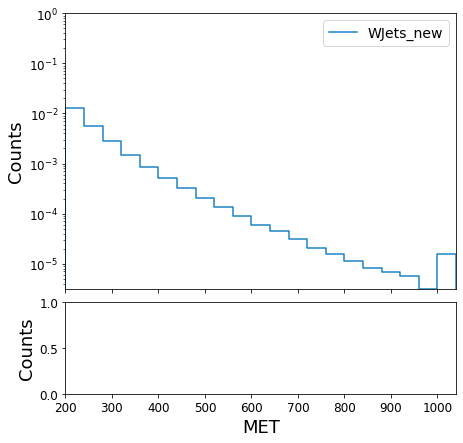

In [24]:
# hists_2017 = output_2017["met"]
# new_pt17_bins = hist.Bin('pt',r'MET',20,200,1000)
# hists_2017 = hists_2017.rebin('pt',new_pt17_bins)
# saveoverlayshape(hists_2017, outdir,"MET_WJets_2017")